In [ ]:
if (!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")
  BiocManager::install("ggrepel")
  BiocManager::install("tidyverse")

In [2]:
BiocManager::install("argparser")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'argparser'




The downloaded binary packages are in
	/var/folders/9j/hx31vvg102g6r3rs7v7_4bw40000gn/T//RtmpoVxUZj/downloaded_packages


Old packages: 'clusterProfiler', 'enrichplot', 'waldo'



In [3]:
.libPaths()

[1] "/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library"

In [2]:
library(ggplot2)
library(ggrepel)  #用于标记的包
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Warning message:
"Removed 1860 rows containing missing values (`geom_text_repel()`)."


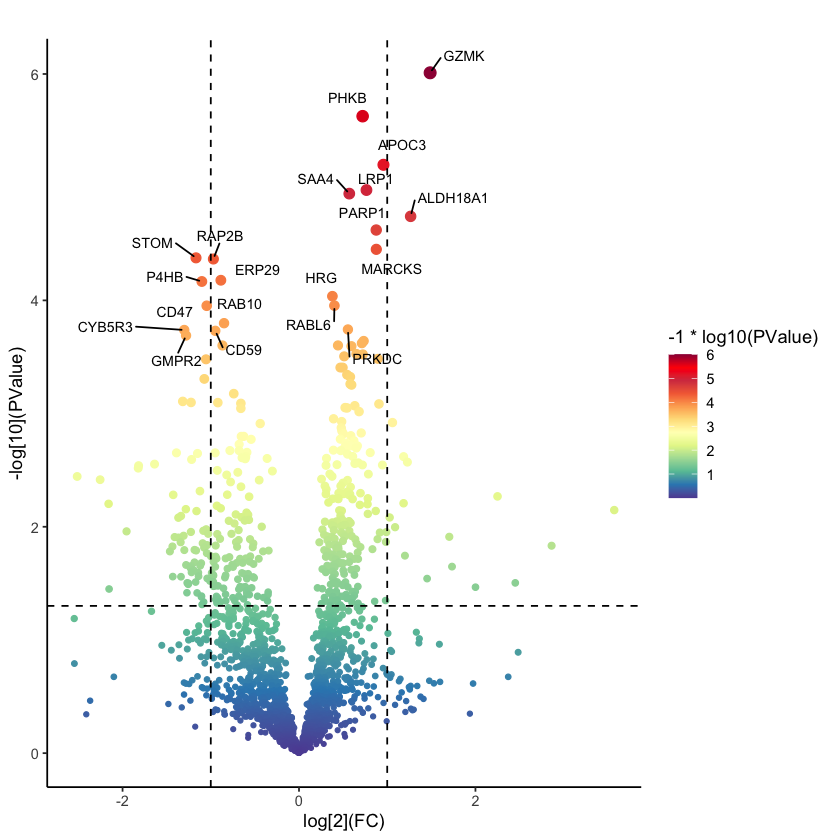

In [12]:
# 读取火山图数据文件
data <- read.delim("demo_deseq3.txt")

FC <- 2 # 用来判断上下调，一般蛋白质组的项目卡1.5
PValue <- 0.05 # 用来判断上下调

# 标记方式（一）
# 根据数据框中的Marker列，1的为标记，其他的为不标记
data$label <- ifelse(data$Marker == 1, as.character(data$Name), "")
# （或）标记方式（二）
# 根据PValue小于多少和log[2]FC的绝对值大于多少筛选出合适的点
# PvalueLimit = 0.0001
# FCLimit = 5
# data$label=ifelse(data$PValue < PvalueLimit & abs(log2(data$FC)) >= FCLimit, as.character(data$Name), '') # nolint

# 绘图
ggplot(data, aes(log2(FC), -1 * log10(PValue))) + # 加载数据，定义横纵坐标
    geom_point(aes(color = -1 * log10(PValue), size = -1 * log10(PValue))) + # 绘制散点图，颜色和大小依据是数据框的PValue列
    scale_color_gradientn(colors = c(
        "#5E4FA2", "#3288BD", "#66C2A5", # 设置渐变色
        "#ABDDA4", "#E6F598", "#FFFFBF",
        "#FEE08B", "#FDAE61", "#F46D43",
        "#D53E4F", "red", "#9E0142"
    )) +
    scale_radius( # 设置点大小图例
        range = c(1, 3), # 设置点大小的范围
        guide = NULL
    ) + # 不显示该图例
    labs(
        title = "", # 定义标题，x轴，y轴名称
        x = "log[2](FC)",
        y = "-log[10](PValue)"
    ) +
    geom_hline(yintercept = -log10(PValue), linetype = 2) + # 在图上添加虚线
    geom_vline(xintercept = c(-log2(FC), log2(FC)), linetype = 2) + # 在图上添加虚线
    geom_text_repel(
        aes(
            x = log2(FC), # geom_text_repel 标记函数
            y = -1 * log10(PValue),
            label = label
        ),
        max.overlaps = 10000, # 最大覆盖率，当点很多时，有些标记会被覆盖，调大该值则不被覆盖，反之。
        size = 3, # 字体大小
        box.padding = unit(0.5, "lines"), # 标记的边距
        point.padding = unit(0.1, "lines"),
        segment.color = "black", # 标记线条的颜色
        show.legend = FALSE
    )  +
    theme_classic()


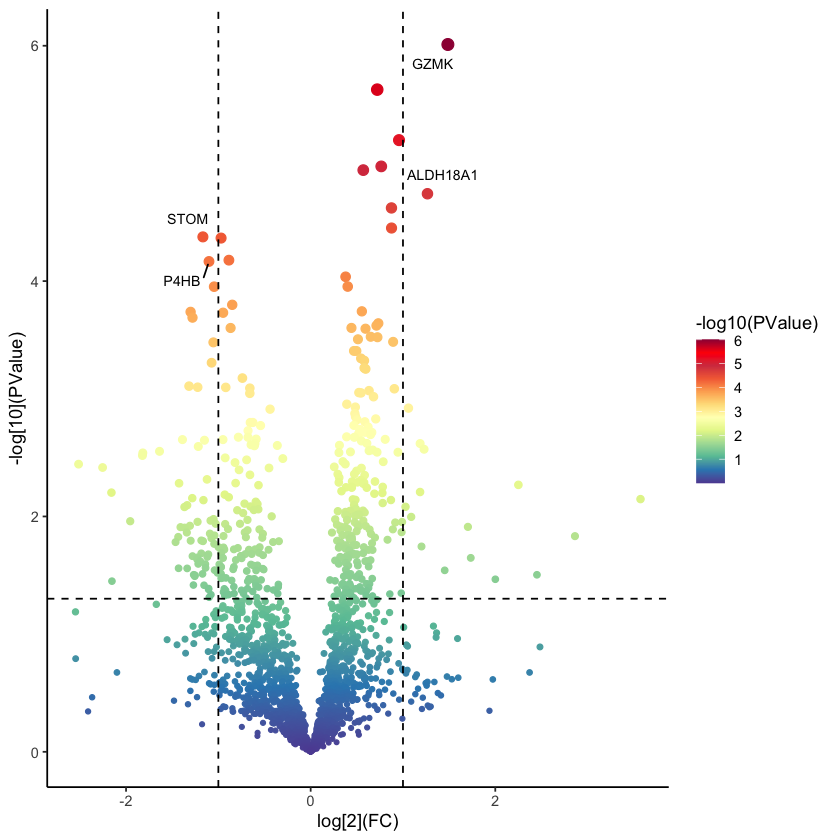

In [49]:
# 函数化火山图的绘制过程
generate_volcano_plot <- function(data_file, key=1, fc_threshold = 2, pvalue_threshold = 0.05) {
    # 读取数据文件
    data <- read.delim(data_file)

    # 如果key=1，那么
    if (key == 1) {
        # 根据PValue小于多少和log[2]FC的绝对值大于多少筛选出合适的点
        data$label <- ifelse(data$Marker == 1, as.character(data$Name), "")
    } 
    # 如果key=2，那么
    if (key ==2) {
        PvalueLimit = 0.0001
        FCLimit = 1
        data$label=ifelse(data$PValue < PvalueLimit & abs(log2(data$FC)) >= FCLimit, as.character(data$Name), '')
    }

    
    # 绘制火山图
    plot <- ggplot(data, aes(log2(FC), -log10(PValue))) +
        geom_point(aes(color = -log10(PValue), size = -log10(PValue))) +
        scale_color_gradientn(colors = c(
            "#5E4FA2", "#3288BD", "#66C2A5", 
            "#ABDDA4", "#E6F598", "#FFFFBF",
            "#FEE08B", "#FDAE61", "#F46D43",
            "#D53E4F", "red", "#9E0142"
        )) +
        scale_radius(range = c(1, 3), guide = NULL) +
        labs(x = "log[2](FC)", y = "-log[10](PValue)") +
        geom_hline(yintercept = -log10(pvalue_threshold), linetype = 2) +
        geom_vline(xintercept = c(-log2(fc_threshold), log2(fc_threshold)), linetype = 2) +
        geom_text_repel(aes(label = label), 
                        max.overlaps = 10000, 
                        size = 3,
                        box.padding = unit(0.5, "lines"), 
                        point.padding = unit(0.1, "lines"),
                        segment.color = "black", 
                        show.legend = FALSE) +
        theme_classic()
    
    return(plot)
}

generate_volcano_plot("demo_deseq3.txt",2)